# HABSlib 102

In this second notebook, we will learn how to define a pipeline and send live data to the browser for visual inspection.

## What is a pipeline?
The building blocks of every OS are small *programs* that perform simple tasks.     
You can use these programs in isolation, giving your *input* and getting the *output*.    
But a more powerful approach is to use them in combination, as a series of steps in a *pipeline*.     
*BrainOS* does the same. It offers a series of programs you can apply to EEG data, and the ability to combine them into reproducible pipelines. *Reproducible* because the parameters for the programs you define using *HABSlib* are stored in the session you create to analyse the data.

In this lesson, you will learn how to create a pipeline session, and how to visualize its data while it unfolds, which will be useful for many practical applications.
    
Please, refer to the documentation of [HABSlib](https://olocufier.github.io/HABSlib/) for further details.

In [1]:
import nest_asyncio # to allow HABSlib to run async in a Jupyter notebook
nest_asyncio.apply()

import HABSlib as hb

## Login
In order to use the HABS API, you need to create a free account on habs.ai/developer.    
This provides you with the **developer IP address** you can use, and a **user ID**, which you will use for all your interaction with the APIs.

The first thing to do to start a session with the HABS BrainOS is to handshake.

In [2]:
hb.handshake(base_url="http://135.237.144.125", user_id='8d60e8693a9560ee57e8eba3')


       HUMAN        AUGMENTED        BRAIN         SYSTEMS     
   ----------------------------------------------------------- 
   ▒▒▒▒     ▒▒▒▒     ░▒▒▒▒▒░     ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒    ░▒▒▒▒▒▒▒░             ░▒▒▒▒ ░▒▒▒░     ░▒░  
   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒ ▒▒▒▒░   ▒▒▒▒▒▒▒▒▒▒▒▒▒   ░▒▒▒▒▒▒▒▒▒░   
   ▒▒▒▒     ▒▒▒▒  ░▒▒▒▒   ▒▒▒▒░  ▒▒▒▒     ░▒▒▒▒ ░▒░     ░▒▒▒░  
   ▒▒▒▒     ▒▒▒▒ ░▒▒▒▒     ▒▒▒▒░ ▒▒▒▒▒▒▒▒▒▒▒▒░   ░▒▒▒▒▒▒▒▒▒░   
   ----------------------------------------------------------- 
   version: 0.1.35

Handshake (RSA) successful.
Handshake (AES) successful.


True

## Acquire data and send
For this tutorial, we use the synthetic board included in the HABSlib, which allows you to define:
- number of EEG channels ('eeg_channels')
- sampling frequency of the channels ('sampling_rate')
- level of noise ('noise' between 0, no noise, and 1)
- probability of observing a generic artifact ('artifacts')
- type of envelope modulation of the EEG (currently 'sinusoidal', at 0.1Hz, or 'random', with mean=0 var=1)
- amplitude in each of the frequency bands ('delta_amp', 'theta_amp', ...)
- some 'preset' amplitude contents for different states ('focus', 'alert', 'relaxed', 'drowsy')
- the presets can be put in a sequence to vary the signal over time
- correlation can be introduced between nearby channels ('correlation_strength')
- given that the PSD of EEG often follows a power-law relationship, we can provide its slope

As you can see, there are quite a number of options to play with even without an actual EEG device ;)

**IMPORTANT NOTE 1**: this EEG simulator takes the same amount of time of a user recording 20 sec during a session. You should see this output:
```
Metadata validation successful!
Connecting to the headset...
Headset connected successfully!
....                              <<<<---- these points!
Stopping data streaming...
Releasing session...
```

**IMPORTANT NOTE 2**: all sessions allow you to see the data while is being recorded on the BrainOS. You should see this output:
```
Session initialized. You can visualize it here:
  https://habs.ai/bos/live.html?session_id=669a8120cc485c74bb9511ab 
```
By clicking the link, a page will be opened in your browser where you will be able to inspect your data interactively!

In [8]:
from datetime import datetime
from scipy import signal

# Pipe setup and sending data
# preprocessing setup, requires a bit of knowledge about the data to process
b_notch, a_notch = signal.iirnotch(50., 2.0, 250)
sos = signal.butter(10, [1, 40], 'bandpass', fs=250, output='sos')

session_id = hb.acquire_send_pipe(
    pipeline='/filtering/artifact/alpha',
    params={ 
        # dictionary, the order does not matter, they will be called by key
        "filtering": {
            'a_notch': a_notch.tolist(),
            'b_notch': b_notch.tolist(),
            'sos': sos.tolist(),
        },
        "artifact":{},
        "alpha":{},
    },
    user_id='8d60e8693a9560ee57e8eba3', 
    date=datetime.today().strftime('%Y-%m-%d'), 

    board="SYNTHETIC",
    extra={
        "eeg_channels": 4,
        "sampling_rate": 250,
        "noise": 1,
        "artifacts": 0.001,
        "modulation_type": 'random',
        "preset": 'focus', # None, # 'focus', 'alert', 'relaxed', 'drowsy'
        "sequence": None, # [("focus", 20), ("relaxed", 20)],
        "correlation_strength": 0.5,
        "power_law_slope": 0.8
    },
    serial_number="",     
    stream_duration=10, # 10 sec
    buffer_duration=5, # 5 sec epoch
    session_type="alpha content", 
    tags=['Happy']
)
print("this session:", session_id)

{'user_id': '8d60e8693a9560ee57e8eba3', 'session_date': '2024-07-19', 'session_type': 'alpha content', 'session_tags': ['Happy']}
Metadata validation successful!
Session successfully created.

Session initialized. You can visualize it here:
  https://habs.ai/bos/live.html?session_id=669a8120cc485c74bb9511ab 

Connecting to the headset...
Headset connected successfully!
..
Stopping data streaming...
Releasing session...
this session: 669a8120cc485c74bb9511ab


## Take your data
Now copy the session_id of the session you just created and paste it below:

In [13]:
import numpy as np

results = hb.get_data_by_session(user_id='8d60e8693a9560ee57e8eba3', session_id='669a8120cc485c74bb9511ab') # <<< past the above session_id here
data = np.array(results)
print(data.shape)
print(data) 

Retrieved data successfully.
(16, 2500)
[[-9.48011781e-01 -8.56395918e+00 -7.04745255e+00 ... -2.02056266e+00
  -6.11949162e-01  2.48809059e+00]
 [ 3.49407413e+00 -7.10323335e-01 -3.44267333e-01 ... -2.54297634e+00
  -1.61216842e+00  1.00223417e+00]
 [-9.56532781e-01 -5.27830047e-01 -2.87573559e+00 ... -1.67688049e+00
  -7.66422958e-01 -2.56283658e+00]
 ...
 [ 1.98672216e+02  2.69758146e+02 -9.12549354e+00 ... -8.83997657e+00
   2.13967817e+02  2.80251069e+02]
 [ 3.15929801e+02  1.23658500e+02  8.13816052e+01 ... -1.06879662e+02
   5.46934819e+02  2.70717837e+02]
 [ 2.75899720e+02 -1.03047177e+02  1.59513030e+02 ...  2.97749750e+01
   5.49180994e+02  5.53526013e+02]]


### Now plot it

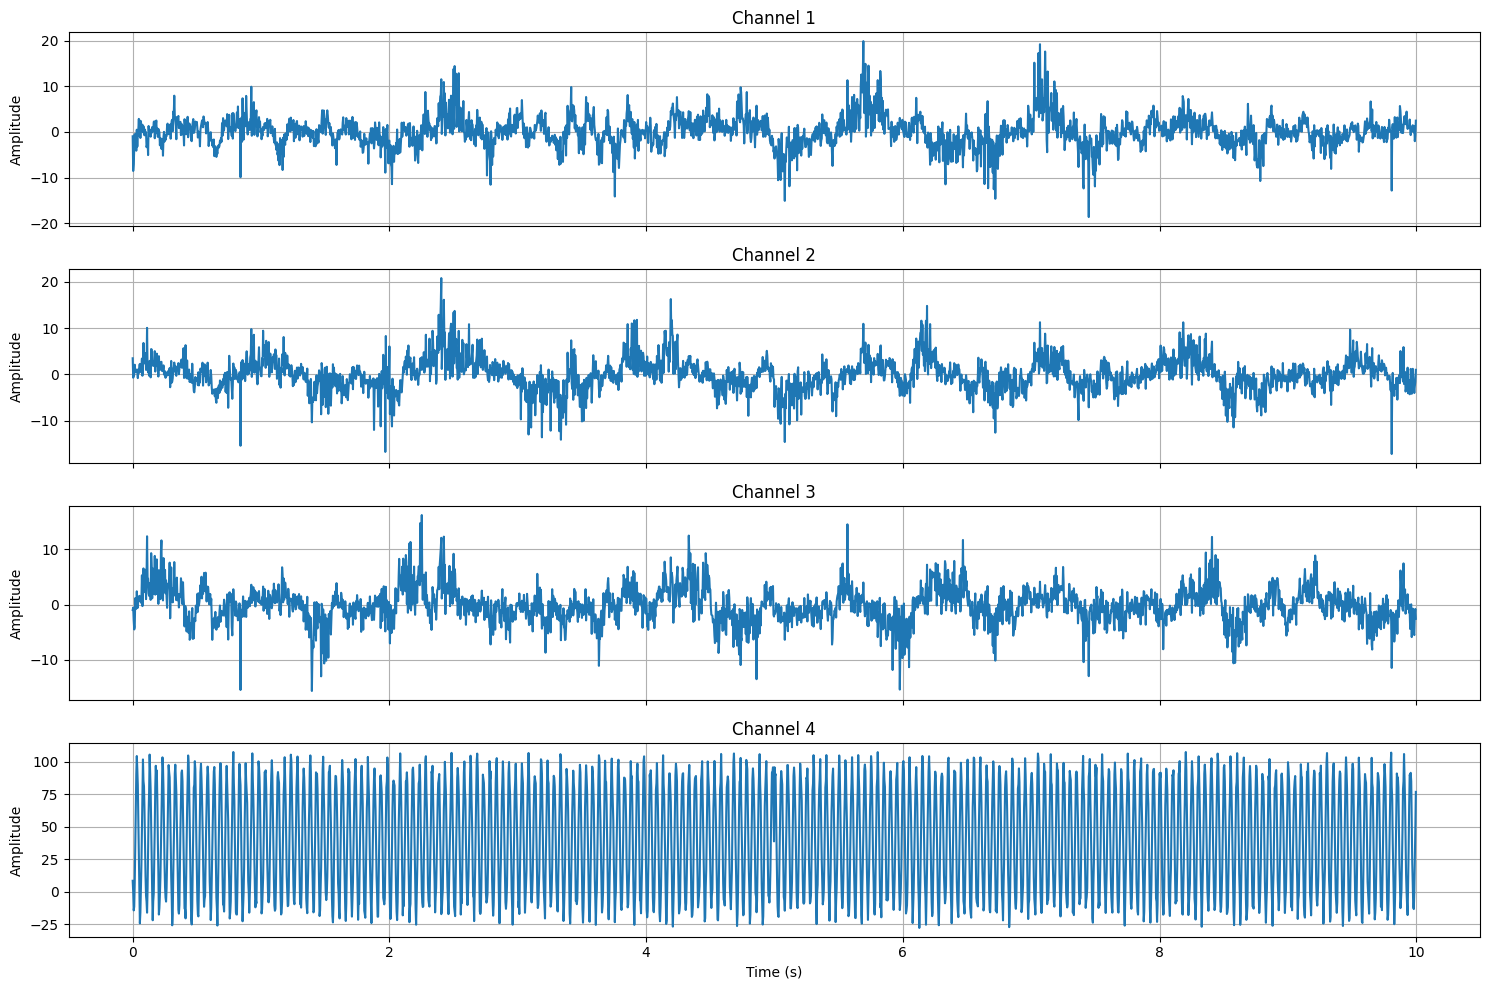

In [14]:
import matplotlib.pyplot as plt

samples_per_second = 250
num_channels=4 # how many you want to plot
    
time = np.arange(data.shape[1]) / samples_per_second
fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i, ax in enumerate(axes[:num_channels]):
    ax.plot(time, data[i])
    ax.set_title(f'Channel {i+1}')
    ax.set_ylabel('Amplitude')
    ax.grid(True)

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

We passed 'focus' as parameter of the dummy EEG generator. This implies the following amplitude proportions:     
```   
            del  the  alp  bet  gam
'focus':   [0.1, 0.1, 0.5, 0.8, 0.4]
```
Is it what we find in the signal if we perform a PSD?

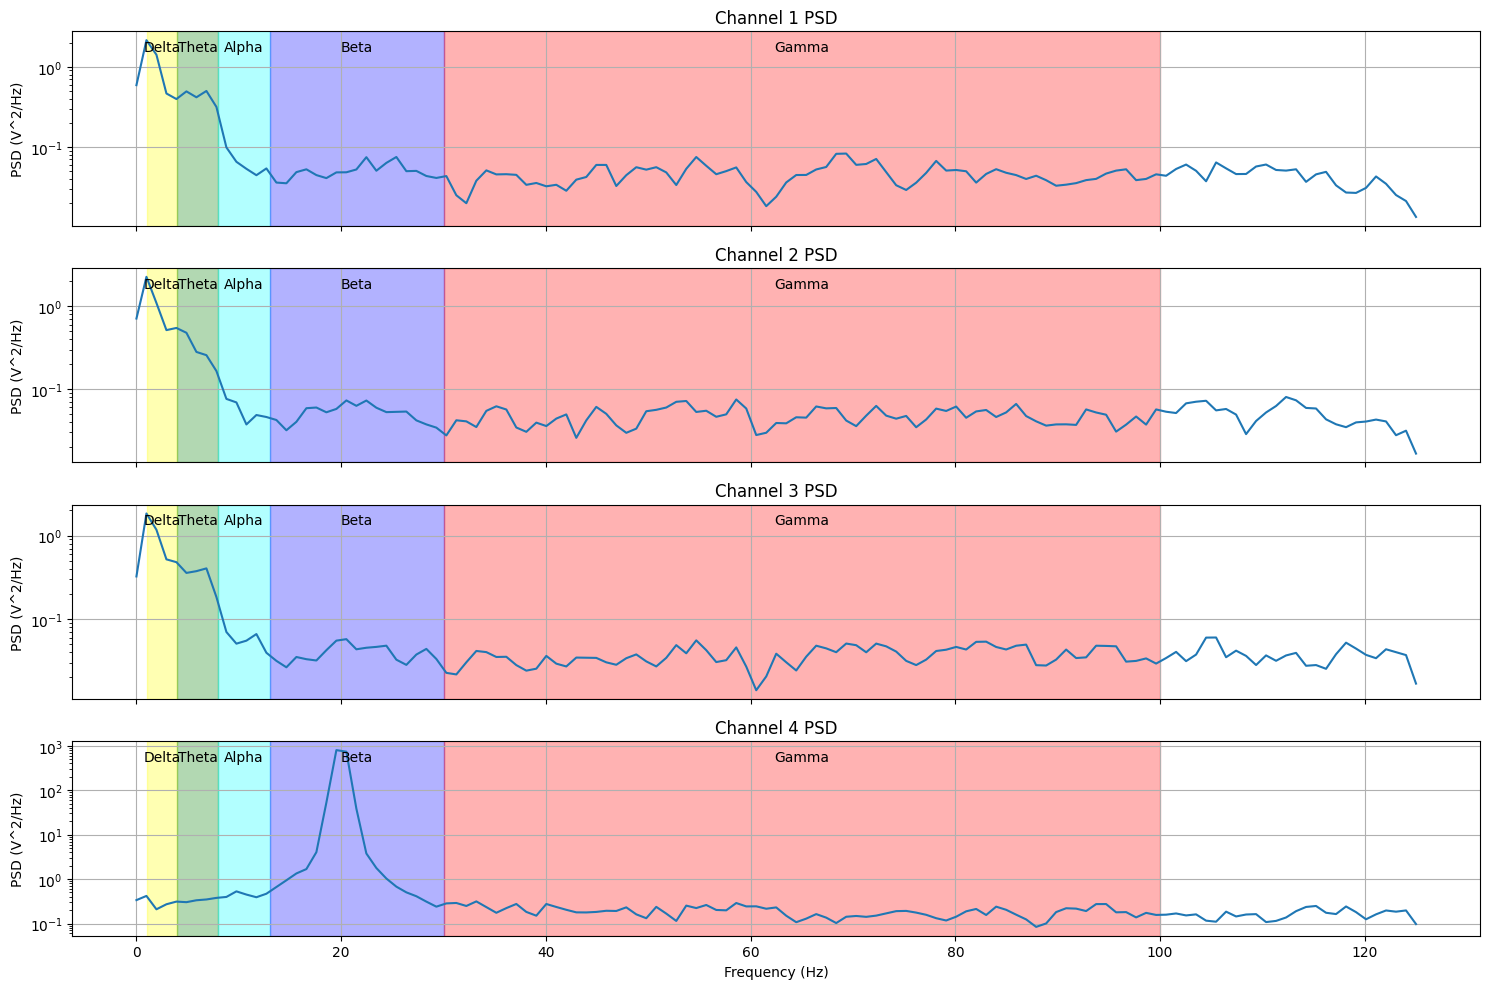

In [15]:
from scipy import signal

# Define frequency bands
bands = {
    'Delta': (1, 4, 'yellow'),
    'Theta': (4, 8, 'green'),
    'Alpha': (8, 13, 'cyan'),
    'Beta': (13, 30, 'blue'),
    'Gamma': (30, 100, 'red')
}

fig, axes = plt.subplots(num_channels, 1, figsize=(15, 10), sharex=True)

if num_channels == 1:
    axes = [axes]

for i in range(num_channels):
    # Plotting the PSD
    freqs, psd = signal.welch(data[i], fs=samples_per_second)
    axes[i].semilogy(freqs, psd)
    axes[i].set_title(f'Channel {i+1} PSD')
    axes[i].set_ylabel('PSD (V^2/Hz)')
    axes[i].grid(True)

    # Highlighting frequency bands
    for band, (low, high,col) in bands.items():
        axes[i].axvspan(low, high, color=col, alpha=0.3)
        axes[i].text((low + high) / 2, max(psd), band, horizontalalignment='center', verticalalignment='top')

axes[-1].set_xlabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

### are we satisfied?
We analysed locally the result of the simulator. It seems from the PSD that there is a relatively higher content of alpha and beta. However, we would need something more sophisticated to decide... this is the content of the [next lesson](notebooks/HABSlib_103.ipynb)!